# Daily Candlestick Color - Detection(Predict, Classification, Clustering)

### Import Library

In [24]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [25]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [26]:
data = dataset.copy()

In [27]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207


## Prepare labels

In [28]:
SL_BY_PERCENT = 0.322
daily_data = data.resample('D').agg({
        'Volume': 'sum',
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min'
    })
daily_data.dropna(subset=['Close'], inplace=True)
daily_data["stoploss"] = daily_data.apply(lambda r: max(r["Open"] * SL_BY_PERCENT / 100, 3), axis=1)
daily_data["LS_able_900"] = daily_data.apply(lambda r: False if (r["High"] > r["Open"] + r["stoploss"] and r["Low"] < r["Open"] - r["stoploss"]) else True , axis=1)
daily_data["Deal"] = daily_data.apply(lambda r: None if r["LS_able_900"] == False else ("Short" if r["Low"] < r["Open"] - r["stoploss"] else "Long"), axis=1)
daily_data["Deal_Int"] = daily_data.apply(lambda r: 0 if r["Deal"] == None else (1 if r["Deal"] == "Long" else 2), axis=1)
daily_data["return"] = daily_data.apply(lambda r: 0 if r["Deal"] == None else (r["Close"] - r["Open"] if r["Deal"] == "Long" else r["Open"] - r["Close"]), axis=1)
daily_data["next_Deal"] = daily_data["Deal_Int"].shift(-1)

In [29]:
daily_data

,Volume,Open,Close,High,Low,stoploss,LS_able_900,Deal,Deal_Int,return,next_Deal
Date,,,,,,,,,,,
2018-08-13,79327,943.5,954.2,954.6,942.3,3.038070,True,Long,1,10.7,0.0
2018-08-14,79266,955.5,959.3,961.8,952.1,3.076710,False,None,0,0.0,0.0
2018-08-15,89449,958.0,946.6,962.3,946.6,3.084760,False,None,0,0.0,0.0
2018-08-16,71410,942.4,947.0,947.3,935.5,3.034528,False,None,0,0.0,2.0
2018-08-17,98531,952.2,947.0,954.6,945.0,3.066084,True,Short,2,5.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10,185266,1333.4,1330.5,1337.6,1325.2,4.293548,True,Short,2,2.9,2.0
2025-02-11,143632,1332.5,1334.1,1334.1,1327.6,4.290650,True,Short,2,-1.6,0.0
2025-02-12,139180,1337.4,1329.5,1342.0,1329.5,4.306428,False,None,0,0.0,0.0


## Feature Engineering

In [30]:
daily_data['RSI_5'] = ta.rsi(daily_data["Close"], length=5)
daily_data['RSI_10'] = ta.rsi(daily_data["Close"], length=10)
daily_data['RSI_22'] = ta.rsi(daily_data["Close"], length=22)
daily_data['ibs'] = daily_data.apply(lambda r: (r["Close"] - r["Low"]) / (r["High"] - r["Low"]), axis=1)
daily_data["ibs_hqua"] = daily_data["ibs"].shift(-1)
daily_data["ibs_hkia"] = daily_data["ibs"].shift(-2)
daily_data["ibs_3htruoc"] = daily_data["ibs"].shift(-3)
daily_data["next_Open"] = daily_data["Open"].shift(-1)
daily_data["NODC"] = daily_data["next_Open"] - daily_data["Close"]
daily_data["NODH"] = daily_data["next_Open"] - daily_data["High"]
daily_data["NODL"] = daily_data["next_Open"] - daily_data["Low"]
daily_data['Close_pct'] = daily_data['Close'].pct_change() * 100
daily_data['Volume_pct'] = daily_data['Volume'].pct_change() * 100
daily_data.dropna(inplace=True)

## AI prediction

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn import metrics
from xgboost import plot_importance
from sklearn.cluster import KMeans

## Kmeans

In [32]:
cluster1 = KMeans(n_clusters=5, n_init=2).fit(daily_data[["RSI_5", "RSI_10", "RSI_22"]])
daily_data = daily_data.assign(cluster1=cluster1.labels_)

In [33]:
cluster2 = KMeans(n_clusters=5, n_init=2).fit(daily_data[["ibs", "ibs_hqua", "ibs_hkia", "ibs_3htruoc"]])
daily_data = daily_data.assign(cluster2=cluster2.labels_)

In [34]:
cluster3 = KMeans(n_clusters=5, n_init=2).fit(daily_data[["NODC", "NODH", "NODL"]])
daily_data = daily_data.assign(cluster3=cluster3.labels_)

In [35]:
cluster4 = KMeans(n_clusters=5, n_init=2).fit(daily_data[["Close_pct", "Volume_pct"]])
daily_data = daily_data.assign(cluster4=cluster4.labels_)

In [36]:
daily_data

,Volume,Open,Close,High,Low,stoploss,LS_able_900,Deal,Deal_Int,return,...,next_Open,NODC,NODH,NODL,Close_pct,Volume_pct,cluster1,cluster2,cluster3,cluster4
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-17,98531,952.2,947.0,954.6,945.0,3.066084,True,Short,2,5.2,...,946.1,-0.9,-8.5,1.1,0.000000,37.979275,2,0,2,4
2018-08-21,83718,944.7,958.5,958.5,944.0,3.041934,True,Long,1,13.8,...,959.5,1.0,1.0,15.5,1.428571,-5.092393,2,0,1,0
2018-08-22,87588,959.5,957.0,960.6,953.6,3.089590,True,Short,2,2.5,...,957.0,0.0,-3.6,3.4,-0.156495,4.622662,2,4,1,4
2018-08-23,84610,957.0,960.6,963.5,955.8,3.081540,True,Long,1,3.6,...,959.5,-1.1,-4.0,3.7,0.376176,-3.400009,2,0,1,0
2018-08-27,56268,960.8,963.2,965.2,960.7,3.093776,True,Long,1,2.4,...,965.9,2.7,0.7,5.2,0.490350,-23.049151,2,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-05,160904,1331.6,1333.5,1337.8,1329.6,4.287752,True,Long,1,1.9,...,1335.6,2.1,-2.2,6.0,0.376364,-6.459864,1,0,1,0
2025-02-06,158566,1335.6,1339.9,1344.9,1335.6,4.300632,True,Long,1,4.3,...,1338.5,-1.4,-6.4,2.9,0.479940,-1.453040,1,4,1,0
2025-02-07,170155,1338.5,1343.3,1347.4,1335.0,4.309970,True,Long,1,4.8,...,1333.4,-9.9,-14.0,-1.6,0.253750,7.308629,1,0,2,4


### Xgboost

In [37]:
# Define Features and Target Variable
features = ["cluster1", "cluster2", "cluster3", "cluster4"]
X = daily_data
y = daily_data["next_Deal"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[features]
X_test2 = X_test[features]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test2_scaled = scaler.fit_transform(X_test2)

In [38]:
# Create XGBClassifier model
model_xgb = xgb.XGBClassifier(n_estimators=50, random_state=42)

# Train XGBClassifier
model_xgb = model_xgb.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y2_pred = model_xgb.predict(X_test2)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y2_pred))

Accuracy: 0.34913793103448276


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

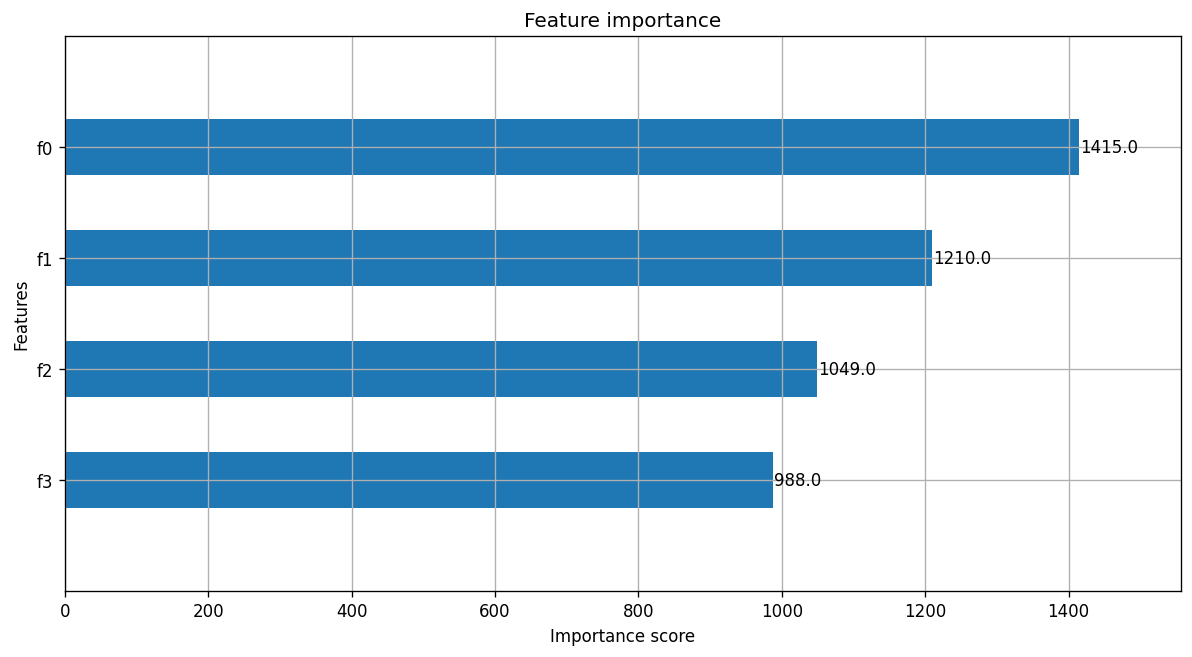

In [39]:
plot_importance(model_xgb, max_num_features=20, height=0.5)